# 101068721

# Can we predict if a song will have positive engagement or not on YouTube?

In this notebook, the dataset will be preprocessed and three regression algorithms will be used to find the likes to view ratio which is taken as the positive engagement. 

###### Loading data and general inspection
- Creating new column for Likes/Views
- Checking data type and values 

###### Data Cleaning 
- Checking for duplicate values 
- Handling missing values 
- Handling categorical values (Licensed  and Official_Video column)
- Handling outliers
- Handling single value columns and near zero variance columns 
- Data tranformation(normalisation of few columns)

###### Data modelling and evaluation 
- Random forest model 
- Data evaluation on training set (RF)
- Hyperparameter tuning(RF)
- Data evaluation on test set (RF)
- XGBoost model 
- hyperparameter tuning (XGB)
- Data evaluation on test set (XGB)
- Linear regression model 
- Data evaluation on training set (LR)
- Data evaluation on test set (LR)
- Comparison of r2 value of the three models


###### Data visualisation
- Learning curve 
- Actual Vs predicted value 
- Residual Vs fitted

# 1. Loading and general inspection

 Importing Libraries 

In [1]:
import warnings
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Removing warnings
warnings.filterwarnings("ignore")

Importing the dataset for analysis

In [3]:
data = pd.read_csv("Spotify_Youtube.csv")

Checking the shape of data to understand how many columns and rows are there

In [4]:
data.shape

(20718, 28)

Checking the first 4 rows to see all the columns. It is transposed since there are several columns and all columns are not visible when we check without transposing the dataset. 

In [5]:
data.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
Artist,Gorillaz,Gorillaz,Gorillaz,Gorillaz,Gorillaz
Url_spotify,https://open.spotify.com/artist/3AA28KZvwAUcZu...,https://open.spotify.com/artist/3AA28KZvwAUcZu...,https://open.spotify.com/artist/3AA28KZvwAUcZu...,https://open.spotify.com/artist/3AA28KZvwAUcZu...,https://open.spotify.com/artist/3AA28KZvwAUcZu...
Track,Feel Good Inc.,Rhinestone Eyes,New Gold (feat. Tame Impala and Bootie Brown),On Melancholy Hill,Clint Eastwood
Album,Demon Days,Plastic Beach,New Gold (feat. Tame Impala and Bootie Brown),Plastic Beach,Gorillaz
Album_type,album,album,single,album,album
Uri,spotify:track:0d28khcov6AiegSCpG5TuT,spotify:track:1foMv2HQwfQ2vntFf9HFeG,spotify:track:64dLd6rVqDLtkXFYrEUHIU,spotify:track:0q6LuUqGLUiCPP1cbdwFs3,spotify:track:7yMiX7n9SBvadzox8T5jzT
Danceability,0.818,0.676,0.695,0.689,0.663
Energy,0.705,0.703,0.923,0.739,0.694
Key,6.0,8.0,1.0,2.0,10.0


Creating the "Likes/Views" column based on Likes and Views columns. This column is created so that the regression models can train on it and predict the likes/views values. 

In [6]:
data["Likes/Views"] = data["Likes"]/data["Views"]

Few of the columns which won't be needed for the analysis are dropped now. Further columns will be dropped based on pearson and spearman correlation which will be done subsequently in this notebook. 

In [7]:
data.drop(columns = ["Url_spotify", 
           "Track",
           "Album", 
           "Album_type", 
           "Uri", 
           "Title",
           "Channel",
           "Views",
           "Likes",
           "Description", 
           "Url_youtube"], inplace = True)

The value counts are checked to see the possible unique values in  all numerical columns in descending order to understand the columns better.  

In [8]:
columns = ["Danceability", "Energy", 
            "Loudness", "Speechiness", "Acousticness", 
             "Instrumentalness", "Valence",
            "Tempo", "Stream", "Comments", "Likes/Views"]

for i in columns:
    print(data[i].value_counts())

0.6870    78
0.6710    74
0.6260    69
0.6470    68
0.6820    67
          ..
0.0889     1
0.0839     1
0.1300     1
0.1250     1
0.0712     1
Name: Danceability, Length: 898, dtype: int64
0.57200    60
0.71100    57
0.72000    57
0.78500    56
0.76800    56
           ..
0.03930     1
0.06020     1
0.00451     1
0.00647     1
0.99900     1
Name: Energy, Length: 1268, dtype: int64
-7.818    25
-7.768    21
-4.501    16
-6.887    15
-6.253    14
          ..
-7.934     1
-8.574     1
-9.118     1
-8.689     1
-3.055     1
Name: Loudness, Length: 9417, dtype: int64
0.0324    72
0.0305    68
0.0317    65
0.0288    65
0.0326    64
          ..
0.8660     1
0.7180     1
0.8690     1
0.9550     1
0.5340     1
Name: Speechiness, Length: 1303, dtype: int64
0.114000    50
0.161000    49
0.117000    45
0.105000    44
0.118000    41
            ..
0.005400     1
0.000055     1
0.000415     1
0.000757     1
0.000575     1
Name: Acousticness, Length: 3138, dtype: int64
0.000000    9391
0.000014    

To see the datatypes of each column, data.dtypes command is used. There are three object datatype colums: Artist, Licensed and official_video. 

In [9]:
data.dtypes

Unnamed: 0            int64
Artist               object
Danceability        float64
Energy              float64
Key                 float64
Loudness            float64
Speechiness         float64
Acousticness        float64
Instrumentalness    float64
Liveness            float64
Valence             float64
Tempo               float64
Duration_ms         float64
Comments            float64
Licensed             object
official_video       object
Stream              float64
Likes/Views         float64
dtype: object

# 2. Data Cleaning

# 2.1 Duplicate values  

Checking for duplicate values in the dataset and there are no duplicate values in the dataset. 

In [10]:
# Checking for duplicate values 
dups = data.duplicated()
data[dups]

,Unnamed: 0,Artist,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Comments,Licensed,official_video,Stream,Likes/Views


# 2.2 Missing values 

Missing values cannot be handled by several models and hence it needs to be handled. Checking the missing values, we can see that the maximum number of missing values are in comments column which has 569 missing values. 

In [11]:
data.isnull().sum()

Unnamed: 0            0
Artist                0
Danceability          2
Energy                2
Key                   2
Loudness              2
Speechiness           2
Acousticness          2
Instrumentalness      2
Liveness              2
Valence               2
Tempo                 2
Duration_ms           2
Comments            569
Licensed            470
official_video      470
Stream              576
Likes/Views         542
dtype: int64

To understand if all the missing values in different columns are missing in same row or not, we plot a misisng value plot to visualise the missingness. If they are all in different rows, deleting the missing rows, might lead to us loosing a huge chunk of the dataset. We can see from the below matrix that several of the missingness are happening in same rows over the entire columns. Hence deleting these missing value rows, would not create a huge impact on the dataset.  

In [12]:
#pip install missingno

<Axes: >

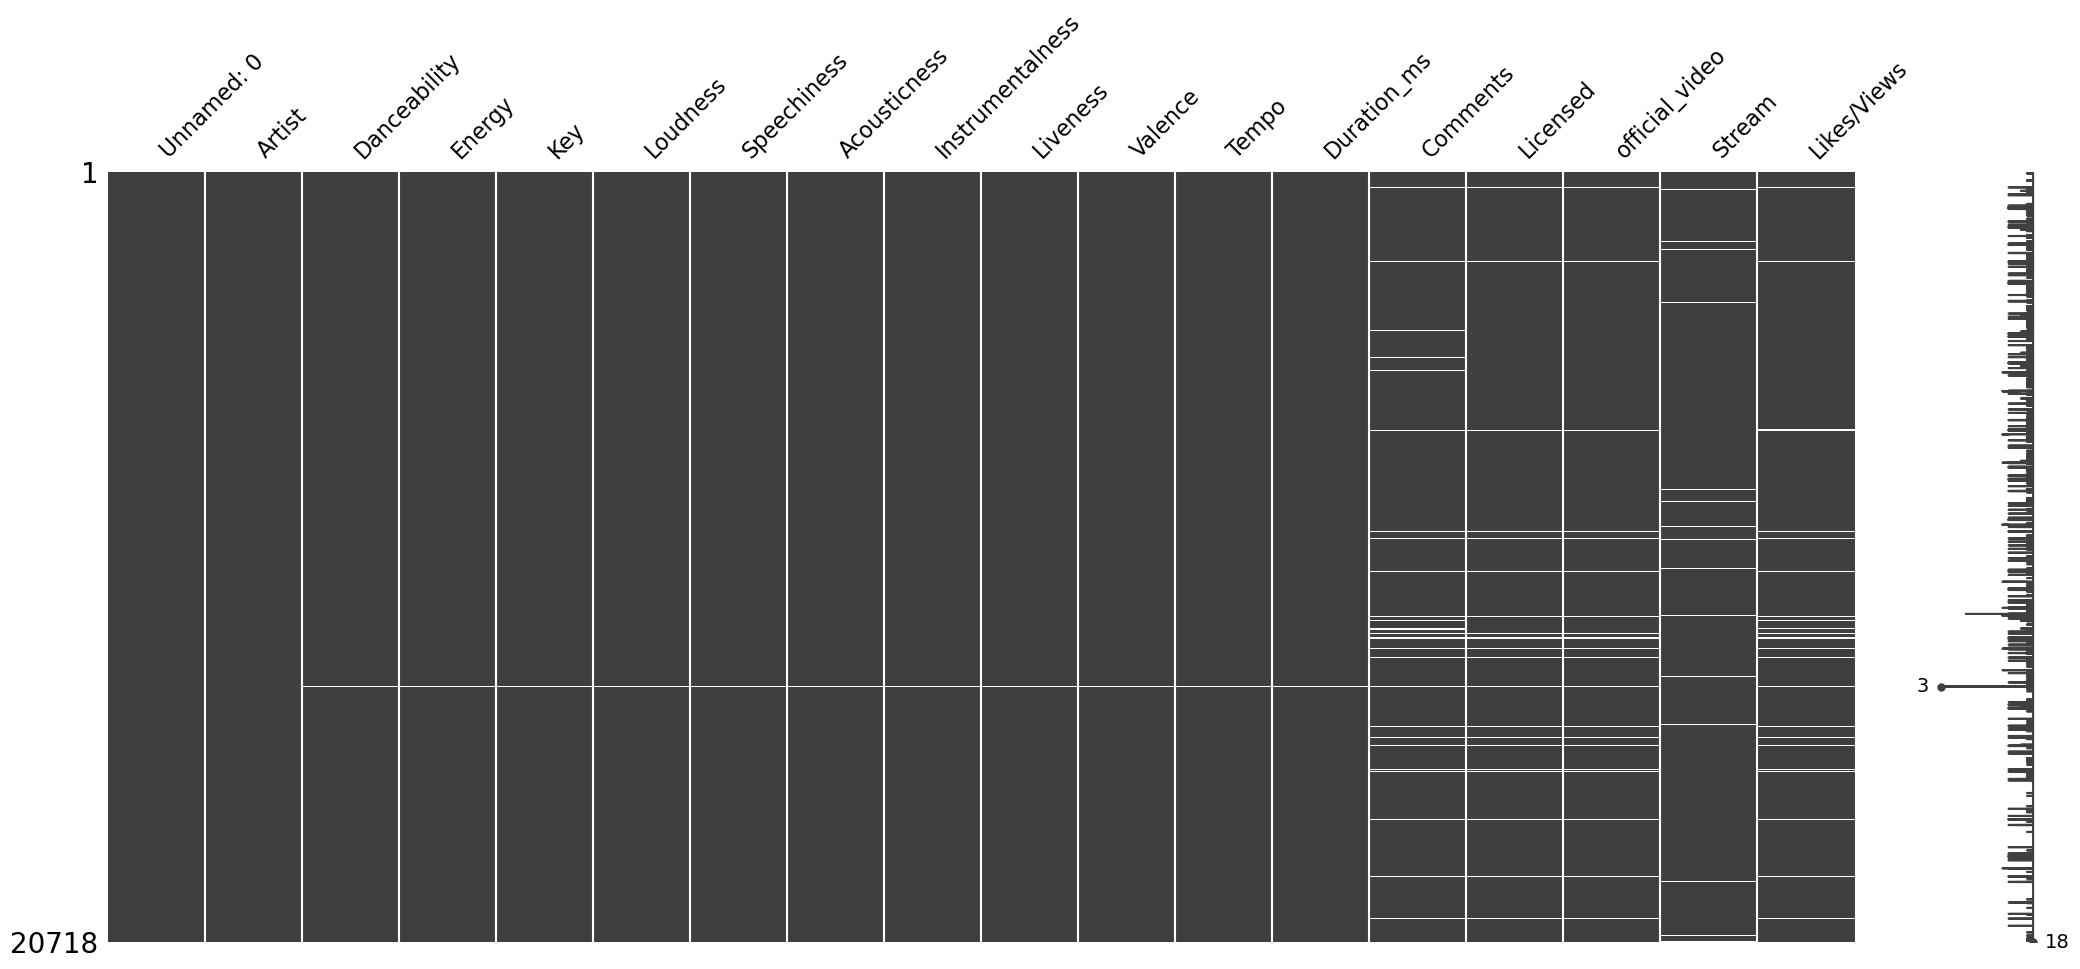

In [13]:
# plotting missing data 
msno.matrix(data)

All the missing values in the dataset are replaced by NAN values so it is easier to handle them

In [14]:
data.replace("",np.nan)

,Unnamed: 0,Artist,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Comments,Licensed,official_video,Stream,Likes/Views
0,0,Gorillaz,0.818,0.705,6.0,-6.679,0.1770,0.008360,0.002330,0.6130,0.7720,138.559,222640.0,169907.0,True,True,1.040235e+09,0.008970
1,1,Gorillaz,0.676,0.703,8.0,-5.815,0.0302,0.086900,0.000687,0.0463,0.8520,92.761,200173.0,31003.0,True,True,3.100837e+08,0.014985
2,2,Gorillaz,0.695,0.923,1.0,-3.930,0.0522,0.042500,0.046900,0.1160,0.5510,108.014,215150.0,7399.0,True,True,6.306347e+07,0.033449
3,3,Gorillaz,0.689,0.739,2.0,-5.810,0.0260,0.000015,0.509000,0.0640,0.5780,120.423,233867.0,55229.0,True,True,4.346636e+08,0.008446
4,4,Gorillaz,0.663,0.694,10.0,-8.627,0.1710,0.025300,0.000000,0.0698,0.5250,167.953,340920.0,155930.0,True,True,6.172597e+08,0.010020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20713,20713,SICK LEGEND,0.582,0.926,5.0,-6.344,0.0328,0.448000,0.000000,0.0839,0.6580,90.002,94667.0,0.0,True,True,9.227144e+06,0.015528
20714,20714,SICK LEGEND,0.531,0.936,4.0,-1.786,0.1370,0.028000,0.000000,0.0923,0.6570,174.869,150857.0,0.0,True,True,1.089818e+07,0.012256
20715,20715,SICK LEGEND,0.443,0.830,4.0,-4.679,0.0647,0.024300,0.000000,0.1540,0.4190,168.388,136842.0,0.0,True,True,6.226110e+06,0.009230
20716,20716,SICK LEGEND,0.417,0.767,9.0,-4.004,0.4190,0.356000,0.018400,0.1080,0.5390,155.378,108387.0,0.0,True,True,6.873961e+06,0.013470


Dropping all the missing values in the dataset as most of the ML models cannot handle missing values. 

In [15]:
data = data.dropna(axis=0)

Checking the shape of the data to make sure, the number of rows deleted are not a lot. The dataset still has 19549 rows. 

In [16]:
data.shape

(19549, 18)

# 2.3 Categorical Encoding

Most machine learning models cannot handle categorical variables, hence they need to be encoded. There are three columns which has categorical variables. The columns are Artist, Licensed, official_video. Based on the dataset snippet from above, it can be seen that Licensed and official video column only has only boolean values True and False. Since it only has two values a label encoder is used. Artist column has multiple unique values and has high cardinal space, hence it is not encoded here using an ordinal encoder as the model might assume a ordinal relationship between variables. It will be encoded after splitting data using target encoding. 

In [17]:
# Initialising label encoder
le = LabelEncoder()
# Encoding both the columns
data["Licensed"] = le.fit_transform(data["Licensed"])
data["official_video"] = le.fit_transform(data["official_video"])
#data["Artist"] = le.fit_transform(data["Artist"])

# 2.4 Outliers 

Checking the data.describe to see the statistical distribution of data including mean, standard deviation etc. to see the outliers, however due to lack of data on how scores are calculated, none of the values are removed. 

In [18]:
data.describe()

,Unnamed: 0,Danceability,Energy,Key,Loudness,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,Comments,Licensed,official_video,Stream,Likes/Views
count,19549.000000,19549.000000,19549.000000,19549.000000,19549.000000,19549.000000,19549.000000,19549.000000,19549.000000,19549.000000,19549.000000,1.954900e+04,1.954900e+04,19549.000000,19549.000000,1.954900e+04,19549.000000
mean,10409.282777,0.621059,0.635170,5.294337,-7.633179,0.095392,0.289106,0.055292,0.191226,0.528950,120.605702,2.246281e+05,2.786371e+04,0.702184,0.780603,1.371101e+08,0.012210
std,5987.965438,0.165489,0.213555,3.579338,4.618839,0.106243,0.285908,0.192519,0.165197,0.245228,29.619340,1.269126e+05,1.959074e+05,0.457310,0.413849,2.463589e+08,0.011198
min,0.000000,0.000000,0.000020,0.000000,-46.251000,0.000000,0.000001,0.000000,0.014500,0.000000,0.000000,3.098500e+04,0.000000e+00,0.000000,0.000000,6.574000e+03,0.000000
25%,5214.000000,0.519000,0.508000,2.000000,-8.772000,0.035700,0.044400,0.000000,0.094000,0.339000,96.990000,1.802400e+05,5.310000e+02,0.000000,1.000000,1.781089e+07,0.005673
50%,10434.000000,0.639000,0.666000,5.000000,-6.516000,0.050700,0.190000,0.000002,0.125000,0.536000,119.964000,2.132530e+05,3.343000e+03,1.000000,1.000000,4.979139e+07,0.008774
75%,15620.000000,0.742000,0.797000,8.000000,-4.929000,0.104000,0.470000,0.000433,0.234000,0.725000,139.951000,2.519200e+05,1.449300e+04,1.000000,1.000000,1.390828e+08,0.014985
max,20717.000000,0.975000,1.000000,11.000000,0.920000,0.964000,0.996000,1.000000,1.000000,0.993000,243.372000,4.676058e+06,1.608314e+07,1.000000,1.000000,3.386520e+09,0.249204


The outliers in all feature space apart from Artist is checked. Artist is not yet included as it is not encoded yet. There are 604 outliers which are removed. 

In [19]:
from sklearn.neighbors import LocalOutlierFactor
df = data[["Danceability", "Energy", 
           "Key", "Loudness",
           "Speechiness", "Acousticness", 
           "Instrumentalness", "Liveness", 
           "Valence", "Tempo", 
           "Duration_ms", "Comments", 
           "Licensed", "official_video", "Stream"]]

# Initialising LocalOutlierFactor 
lof = LocalOutlierFactor()
yhat = lof.fit_predict(df)
# Masking  values that are not outliers 
mask = yhat!=-1
# counting number of rows that are outliers
data[mask].count()

Unnamed: 0          18945
Artist              18945
Danceability        18945
Energy              18945
Key                 18945
Loudness            18945
Speechiness         18945
Acousticness        18945
Instrumentalness    18945
Liveness            18945
Valence             18945
Tempo               18945
Duration_ms         18945
Comments            18945
Licensed            18945
official_video      18945
Stream              18945
Likes/Views         18945
dtype: int64

In [20]:
data = data[mask]

# 2.6 Single value columns

Columns with zero variance does not help the model in prediction and hence can be removed. Checking for single value columns, it can be seen that there are no zero value columns.

In [21]:
data.nunique()

Unnamed: 0          18945
Artist               2038
Danceability          880
Energy               1218
Key                    12
Loudness             8882
Speechiness          1257
Acousticness         3070
Instrumentalness     3858
Liveness             1506
Valence              1264
Tempo               13948
Duration_ms         13565
Comments            10095
Licensed                2
official_video          2
Stream              17445
Likes/Views         18169
dtype: int64

Checking near zero variance columns, where the variance is less than 1%. We see that official video, Licensed and Key column has less than 1% of unique values. 

In [22]:
for i in range(data.shape[1]):
# Finding number of unique values in each column 
    num = data.nunique() [i]
# Computing the percentage of unique values wrt the number of rows 
    percentage = float(num)/data.shape[0]*100
    if percentage <= 1:
        print(i, num, percentage)

4 12 0.06334125098970705
14 2 0.010556875164951175
15 2 0.010556875164951175


Before removing these columns, checking the correlation of each variable to likes/views which is the target variable. We see that Licensed has better correlation than several other variables. Key and official_video has less negative correlation. 

Text(0.5, 1.0, 'Pearson Correlation')

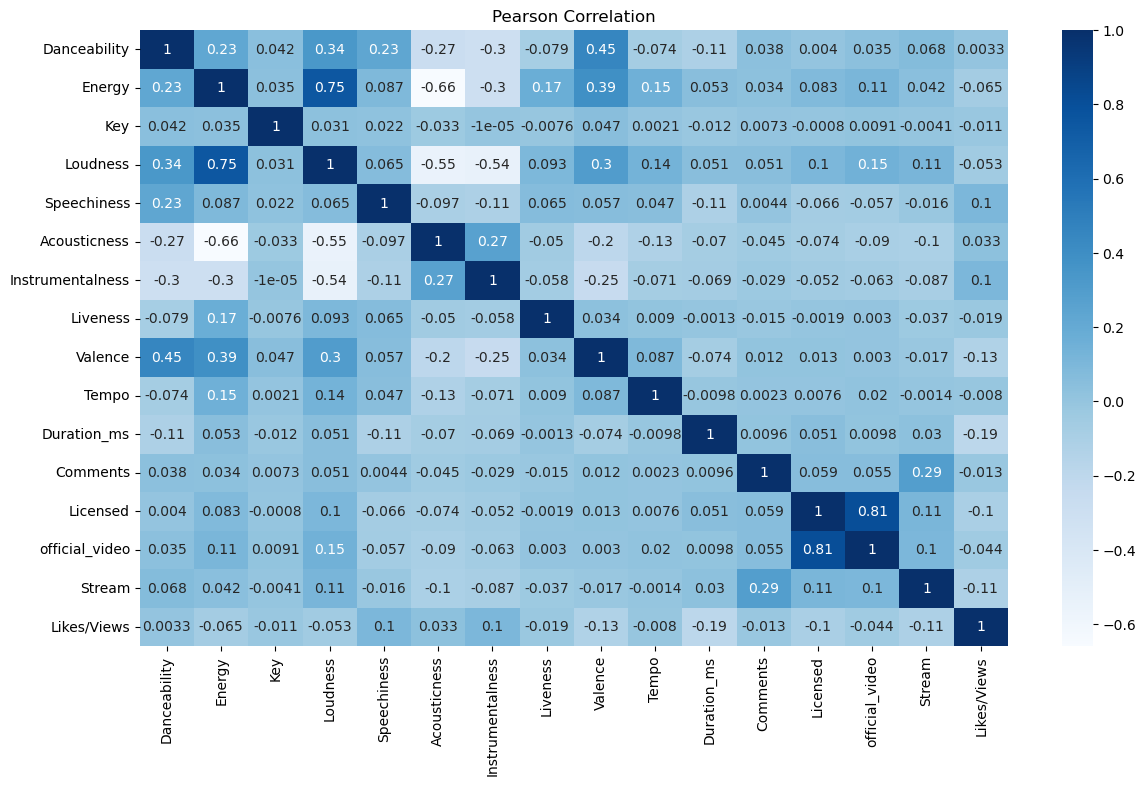

In [23]:
correlation_var = data[["Danceability", "Energy", 
                        "Key", "Loudness", 
                        "Speechiness", "Acousticness", 
                        "Instrumentalness", "Liveness",
                        "Valence", "Tempo", 
                        "Duration_ms", "Comments", 
                        "Licensed", "official_video",
                        "Stream","Likes/Views"]]

# Setting the size of the graph 
fig, ax = plt.subplots(figsize=(14,8))
# plotting the correlation matrix 
sns.heatmap(correlation_var.corr(method="pearson"), cmap="Blues", annot=True)
plt.title("Pearson Correlation")

Using spearman correlation, we can see the monotonic relationship between variables and the Likes/Views column. Key has very less correlation with Likes/Views and hence dropped. Some other columns with comparitively less montonic correlation, Danceability, Acousticness, Liveness and Tempo are also dropped.  

Text(0.5, 1.0, 'Spearman Correlation')

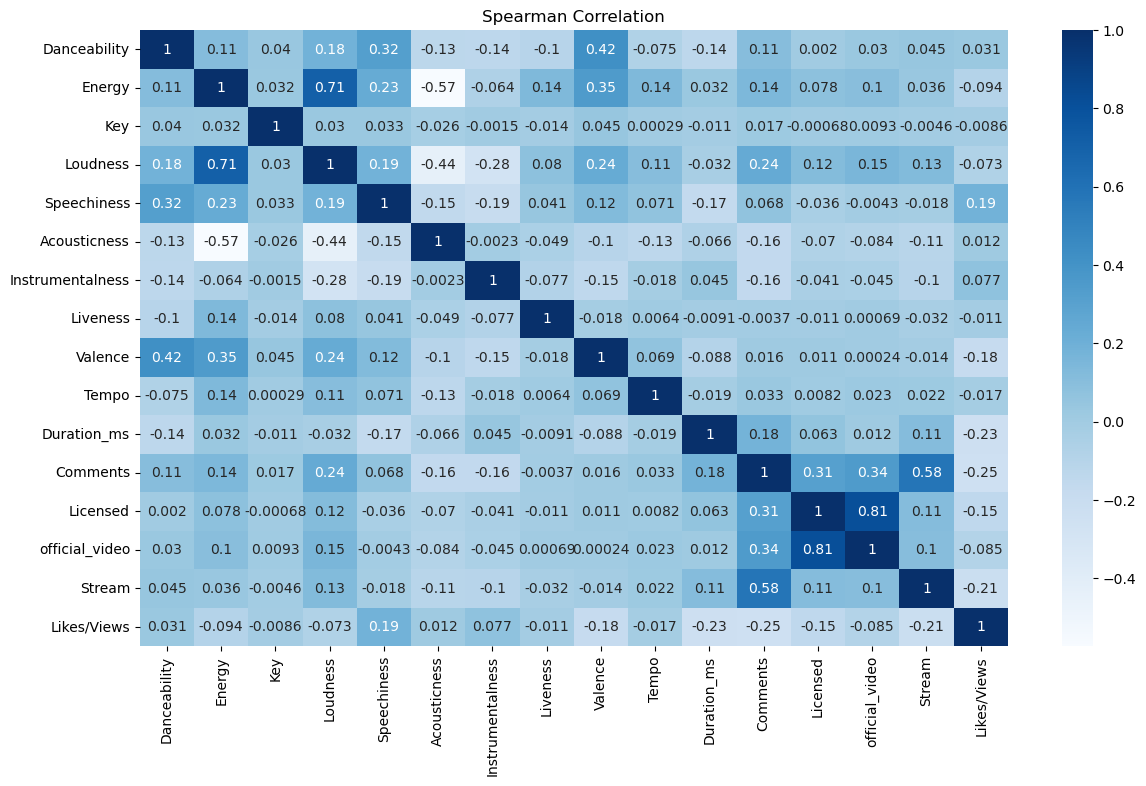

In [24]:
# Setting the size of the graph 
fig, ax = plt.subplots(figsize=(14,8))
# plotting the correlation matrix 
sns.heatmap(correlation_var.corr(method="spearman"), cmap="Blues", annot=True)
plt.title("Spearman Correlation")

In [25]:
data = data[["Artist", "Energy", 
             "Loudness", "Speechiness",
             "Instrumentalness", "Valence", 
             "Duration_ms", "Comments", 
             "Licensed", "Stream", "Likes/Views"]]

# 2.7 Data transformations

Checking the statistical information of data to see the distribution of the data and decide whether to normalise the data or standardise the data. We can see that Energy, Speechiness, Instrumentalness, Valence, Licensed and Likes/Views are between the ranges 0 and 1 and does not need to be normalised. 

In [26]:
data.describe()

,Energy,Loudness,Speechiness,Instrumentalness,Valence,Duration_ms,Comments,Licensed,Stream,Likes/Views
count,18945.000000,18945.000000,18945.000000,18945.000000,18945.000000,18945.000000,1.894500e+04,18945.000000,1.894500e+04,18945.000000
mean,0.636844,-7.546004,0.095247,0.051643,0.530925,217704.276801,2.453217e+04,0.701188,1.395064e+08,0.012173
std,0.211270,4.462029,0.105897,0.185331,0.243970,57996.950786,1.802092e+05,0.457749,2.458893e+08,0.011111
min,0.000055,-46.251000,0.000000,0.000000,0.000000,31000.000000,0.000000e+00,0.000000,6.574000e+03,0.000000
25%,0.510000,-8.687000,0.035600,0.000000,0.341000,179775.000000,5.420000e+02,0.000000,1.829579e+07,0.005664
50%,0.666000,-6.490000,0.050500,0.000002,0.537000,212373.000000,3.343000e+03,1.000000,5.146206e+07,0.008755
75%,0.797000,-4.921000,0.104000,0.000389,0.726000,249240.000000,1.430300e+04,1.000000,1.425266e+08,0.014964
max,1.000000,0.920000,0.964000,1.000000,0.993000,611077.000000,1.608314e+07,1.000000,2.538330e+09,0.249204


To understand if the columns follow gaussian distribution, the histogram is plotted. The dataset needs to be standardised only if it follows gaussian distribution. Since most of the columns do not follow gaussian distribution, it is not standardised. 

array([[<Axes: title={'center': 'Energy'}>,
        <Axes: title={'center': 'Loudness'}>,
        <Axes: title={'center': 'Speechiness'}>],
       [<Axes: title={'center': 'Instrumentalness'}>,
        <Axes: title={'center': 'Valence'}>,
        <Axes: title={'center': 'Duration_ms'}>],
       [<Axes: title={'center': 'Comments'}>,
        <Axes: title={'center': 'Licensed'}>,
        <Axes: title={'center': 'Stream'}>],
       [<Axes: title={'center': 'Likes/Views'}>, <Axes: >, <Axes: >]],
      dtype=object)

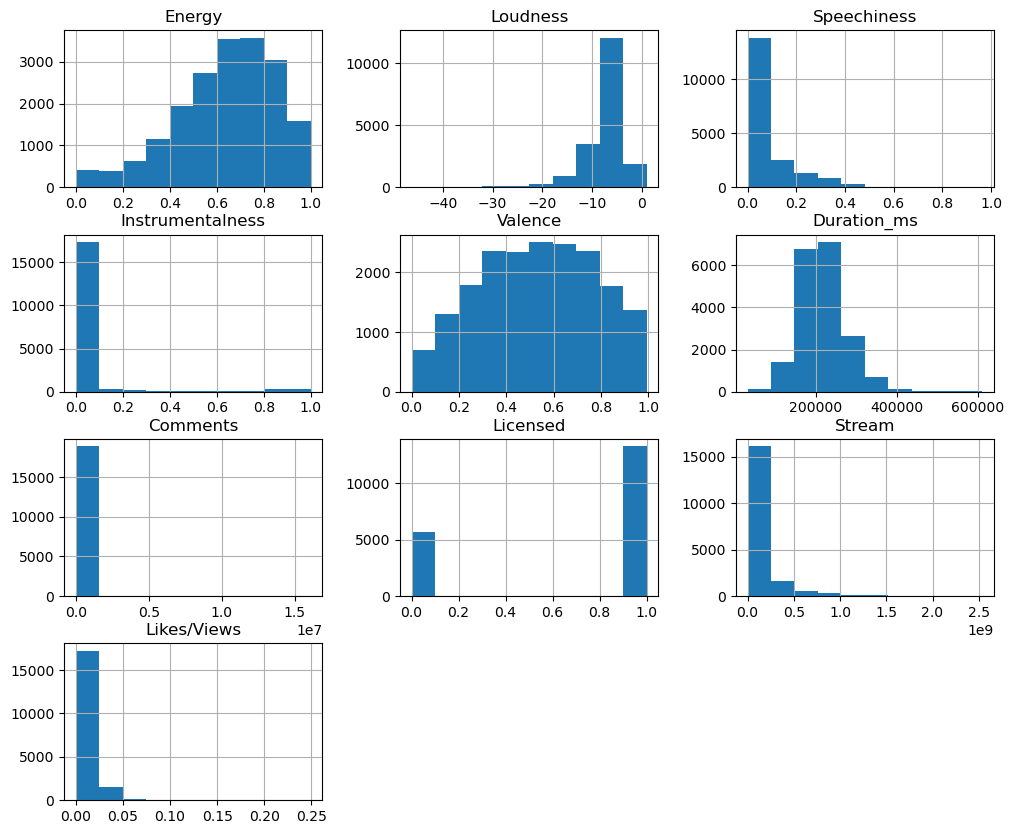

In [27]:
data.hist(figsize=(12,10))

Since the dataset has some of the columns in different ranges, these columns are normalised. Normalisation helps us bring the columns to in between a range of values. It helps the model to perform better and also makes the data more interpretable. The columns are Loudness, Duration_ms, comments and Streams. 

In [28]:
# Selecting the columns for normalisation
scale = data.values[:,[1, 5, 6, 8]]
trans = MinMaxScaler()
# Fitting the scale onto the columns
scale1 = trans.fit_transform(scale)
# Creating a dataframe for all the columns
scaled = pd.DataFrame(scale1)

Resetting the index of the data so that it does not have any issue while merging two datasets.

In [29]:
data = data.reset_index(drop=True)

Merging the normalised columns into the main dataset so that the model can train based on the entire columns 

In [30]:
data[["Loudness", "Duration_ms", "Comments", "Stream"]] = scaled[[0, 1, 2, 3]]

# 3. Data Modelling 

# 3.1 Data Splitting

In this section, the data is split into training, validation and test set. The training data will be used for training the models and validation set will be used for hypertuning parameters and test set will be used to see how well the model performs with generalised data

In [31]:
np.random.seed(1)

# Setting independent and dependent variables
X = data.drop("Likes/Views", axis=1)
y = data["Likes/Views"]

# Splitting dataset into training data and 20% test data 
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=3)

# Checking the length of training, test and validation set 
print ("Length of dataset:", len(X))
print ("Length of training set:", len(X_train))
print ("Length of validation set:", len(X_val))
print ("Length of test set:", len(X_test))

Length of dataset: 18945
Length of training set: 12124
Length of validation set: 3032
Length of test set: 3789


Since the Artist column will be using target encoding which is encoding based on the target value, it will only be applied to the training set to avoid data leakage. The test and validation set are transformed based on the training data.

In [32]:
import category_encoders as ce


# Initialising the target encoder
target_encoder = ce.TargetEncoder(cols=["Artist"])

# Encoding the training data 
X_train = target_encoder.fit_transform(X_train, y_train)
X_val = target_encoder.fit_transform(X_val, y_val)

# Transforming test and validation set 
X_test = target_encoder.transform(X_test)

# 3.2 Random Forest 

Random forest is used with 10 n_estimators and the MAE score is around 0.0019 and r2 score is around 0.90 suggests that the model is performing well with the training data but this could also be because the model is overfitting as the artist column is encoded using target encoded. The model will be hyperparameter tuned and the model will be tested on test set to see how well it generalises. 

In [33]:
# Initialising Random forest regressor and fitting it onto the training data 
rf = RandomForestRegressor(n_estimators=10, random_state=3)
rf.fit(X_train,y_train)

RandomForestRegressor(n_estimators=10, random_state=3)

# 3.2.1 Training data evaluation

In [34]:
# Making predictions on training data 
y_pred_rf = rf.predict(X_train)

MAE_train_rf = mean_absolute_error(y_train,y_pred_rf)
MSE_train_rf = mean_squared_error(y_train,y_pred_rf)
r2_train_rf = r2_score(y_train,y_pred_rf)

print("Mean Absolute Error training set:", MAE_train_rf)
print("Mean Squared Error of training set:", MSE_train_rf)
print("r2 value train set:",r2_train_rf)

Mean Absolute Error training set: 0.0019619320287339722
Mean Squared Error of training set: 1.1912172423609326e-05
r2 value train set: 0.9049207486440496


The parameters of random forest regressor is checked so as to hyperparamater tune it. 

In [35]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 3,
 'verbose': 0,
 'warm_start': False}

# 3.2.2 Hyperparameter tuning Random Forest

The hyperparameters used for tuning are n_estimators, which decides the total number of trees and max_depth decides the maximum depth of each tree and max_features decides the maximum number of features used for best split. RandomizedSearchCV is used as there are several parameters to check. The hyperparameter tuning is done on validation dataset so as to reduce the computational time, then the model with selected hyperparameters are set on the fitted onto the training data and the the model is checked on unseen data (test set) to see how well the model generalises. 

In [36]:
param_dist = { "n_estimators": [10,50,100,200,300],
             "max_depth": [5, 10, 15],
              "max_features": [0.25, 0.5, 0.75, 1]}
 
random_search = RandomizedSearchCV(estimator = rf,
                                  param_distributions=param_dist, 
                                  n_iter=100, 
                                  cv=5,
                                  verbose=0,
                                  random_state=3)

# Fitting model onto validation set 
random_search.fit(X_val,y_val)

# Finding the best estimators and parameters 
best_params = random_search.best_params_
best_mod = random_search.best_estimator_

print("best parameters",best_params)

# Fitting onto the train data
best_mod.fit(X_train,y_train)

best parameters {'n_estimators': 300, 'max_features': 0.75, 'max_depth': 5}


RandomForestRegressor(max_depth=5, max_features=0.75, n_estimators=300,
                      random_state=3)

# 3.2.3 Test data evaluation

Even though model has less mean absolute error score (around 0.005) compared to the mean of the column (around 0.012), the r2 square value is very low(around 0.09). Even though the difference between prediction and the actual values are not huge, the model is only able explain 9% of the variability and underlying patterns. This shows that the model is overfitting on the training data. 

In [37]:
y_pred_test_rf = best_mod.predict(X_test)

# Calculating MSE, MAE and R2 values 
MAE_test_rf = mean_absolute_error(y_test,y_pred_test_rf)
MSE_test_rf = mean_squared_error(y_test,y_pred_test_rf)
r2_test_rf = r2_score(y_test,y_pred_test_rf)

print("Mean Absolute Error test set:", MAE_test_rf)
print("Mean Squared Error of test set:", MSE_test_rf)
print("r2 value on test set:",r2_test_rf)

Mean Absolute Error test set: 0.005936211278550133
Mean Squared Error of test set: 0.00010085554008501959
r2 value on test set: 0.09665712666869397


# 3.3 XGBoost 

While Random forest uses bagging, XGBoost uses boosting where trees are made sequentially and the errors are corrected from previous trees.

In [38]:
import xgboost as xgb 
from xgboost import XGBRegressor

# Initialising the model
xgb = XGBRegressor(objective = "reg:squarederror",
             n_estimation = 10 ,
             max_depth =  10,
             eta =  0.1)

# Fitting the model onto training data  
xgb.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimation=10,
             n_estimators=None, n_jobs=None, ...)

# 3.3.1 Training data evaluation

The model is performing well on the training data. The model has r2 score of around 0.94 when on training data. The model could be overfitting and this is checked test set after hyperparamter tuning. The chances of overfitting is high because of the usage of target encoder and high chances of data leak. 

In [39]:
# Making predictions on training data 
y_pred_train_xg = xgb.predict(X_train)

# Finding MAE, MSE and R2 values for training set 
MAE_train_xg = mean_absolute_error(y_train,y_pred_train_xg)
MSE_train_xg = mean_squared_error(y_train,y_pred_train_xg)
r2_train_xg = r2_score(y_train,y_pred_train_xg)

print("Mean Absolute Error training set:", MAE_train_xg)
print("Mean Squared Error of training set:", MSE_train_xg)
print("r2 value train set:",r2_train_xg)

Mean Absolute Error training set: 0.0018525409251678444
Mean Squared Error of training set: 7.351023103161653e-06
r2 value train set: 0.9413264223775285


Finding the hyperparameters of XGBoost before hyperparameter tuning

In [40]:
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': 10,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'n_estimation': 10,
 'eta': 0.1}

# 3.3.2 Hyperparameter tuning XGBoost

The model is hyperparameter tuned on n_estimators, max_depth, eta. Due to computational contraints, the hyperparameter tuning is done on validation set and the best model is checked on test set to see how well the model generalises. The hyperparameter tuning is done using randomsearchCV because of the wide number of parameters. 

In [41]:
param_dist = { "n_estimators": [10,50,100,200,300],
             "max_depth": [2, 3, 5, 10],
              "eta": [0.01, 0.1, 0.3]}
 
random_search = RandomizedSearchCV(estimator = xgb,
                                  param_distributions=param_dist, 
                                  n_iter=100, 
                                  cv=5,
                                  verbose=0,
                                  random_state=3)

# Fitting model onto validation set 
random_search.fit(X_val,y_val)

# Finding the best estimators and parameters 
best_params = random_search.best_params_
best_mod = random_search.best_estimator_

print("best parameters",best_params)

# Fitting onto the train data
best_mod.fit(X_train,y_train)

best parameters {'n_estimators': 100, 'max_depth': 2, 'eta': 0.1}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimation=10,
             n_estimators=100, n_jobs=None, ...)

# 3.3.3 Test data evaluation

With the test set, the model's R2 value is bad even after hyper paramater tuning. Even though the mean absolute error value is not bad compared to the mean of the target column, the r2 value is really less. This also shows that the model was overfitting on the training data. The model is only able to explain 7% the variability in the target values.

In [42]:
# Making predictions on training data 
y_pred_test_xg = xgb.predict(X_test)

# Finding MAE, MSE and R2 values for test set 
MAE_test_xg = mean_absolute_error(y_test,y_pred_test_xg)
MSE_test_xg = mean_squared_error(y_test,y_pred_test_xg)
r2_test_xg = r2_score(y_test,y_pred_test_xg)

print("Mean Absolute Error test set:", MAE_test_xg)
print("Mean Squared Error of test set:", MSE_test_xg)
print("r2 value test set:",r2_test_xg)

Mean Absolute Error test set: 0.006041044437325779
Mean Squared Error of test set: 0.00010289261677194156
r2 value test set: 0.0784114387668785


# 3.4 Linear Regression 

The linear regression model is trained on the training data. The model is a simple model and works based on linear relationship between the independent and target variable.

In [43]:
# initialising the linear regression model 
lr = LinearRegression()
# Fitting it onto the training set
lr.fit(X_train, y_train)

LinearRegression()

# 3.4.1 Data evaluation on training data

The model performs badly compared to the training models of both random forest and the XGBoost. The r2 score is only 0.51. The r2 score of xgboost and random forest on training set were more than 0.90. This shows that the model is too simple to capture the patterns in the data. 

In [44]:
# Using the model to make prediction on the train set
y_pred_train_lr = lr.predict(X_train)

# Finding MAE, MSE and R2 values for training set
MAE_train_lr = mean_absolute_error(y_train,y_pred_train_lr)
MSE_train_lr = mean_squared_error(y_train,y_pred_train_lr)
r2_train_lr = r2_score(y_train,y_pred_train_lr)


print("Mean Absolute Error training set:", MAE_train_lr)
print("Mean Squared Error of training set:", MSE_train_lr)
print("r2 value train set:",r2_train_lr)

Mean Absolute Error training set: 0.004731338858739462
Mean Squared Error of training set: 6.03531879888298e-05
r2 value train set: 0.518279644815266


# 3.4.2 Data evaluation on test data 

The model is not hyperparameter tuned as linear regression already uses least square method to find the best fit and it does not have any hyperparameters to tune. The r2 score value is really low like the other two models but is better than XGBoost. However the MAE score is still low indicating that the predicted values are closer to the actual values. 

In [45]:
y_pred_test_lr = lr.predict(X_test)

# Finding MAE, MSE and R2 values for training set
MAE_test_lr = mean_absolute_error(y_test,y_pred_test_lr)
MSE_test_lr = mean_squared_error(y_test,y_pred_test_lr)
r2_test_lr = r2_score(y_test,y_pred_test_lr)


print("Mean Absolute Error test set:", MAE_test_lr)
print("Mean Squared Error of test set:", MSE_test_lr)
print("r2 value test set:",r2_test_lr)

Mean Absolute Error test set: 0.005975641919333737
Mean Squared Error of test set: 0.00010173506910239586
r2 value test set: 0.08877936141092857


# 3.5 Comparison of models

The accuracy score of both training and test data of both the models are compared in this section. Even though the xgboost and random forest models have really high r2 with training data, the models do not have high r2 value with test data even though the mae score is less compared to the mean of the target variable. They are unable to explain the variability in the data. The models are compared using r2 score so as to see how well each model is understanding the underlying patterns and variability. MAE scores are also compared and we can see that the MAE scores are less for each of the models.   The linear regression model also has less r2 score with training set indicating that the model is unable to learn the complex details in the data. 

In [53]:
comparison_df = pd.DataFrame({"models":["Random forest",
                                        "XGBoost",
                                       "Linear regression"],
                             "Training set R2": [r2_train_rf,r2_train_xg,r2_train_lr],
                              " Test set R2": [r2_test_rf,r2_test_xg, r2_test_lr]})

comparison_df

,models,Training set R2,Test set R2
0,Random forest,0.904921,0.096657
1,XGBoost,0.941326,0.078411
2,Linear regression,0.518280,0.088779


In [47]:
comparison_df = pd.DataFrame({"models":["Random forest",
                                        "XGBoost",
                                       "Linear regression"],
                             "Training set MAE": [MAE_train_rf,MAE_train_xg,MAE_train_lr],
                              " Test set MAE": [MAE_test_rf,MAE_test_xg, MAE_test_lr]})

comparison_df

,models,Training set MAE,Test set MAE
0,Random forest,0.001962,0.005936
1,XGBoost,0.001853,0.006041
2,Linear regression,0.004731,0.005976


# 4. Data Visualisation

# 4.1 Learning Curve 

In [48]:
train_sizes, train_scores, test_scores =learning_curve(rf, 
                                                    X_train, y_train,
                                                    cv=5,
                                                    scoring="r2",
                                                    train_sizes=np.linspace(0.1,1,5))

# Calculating the mean of test and train data for random forest
train_mean_rf = train_scores.mean(axis=1)
test_mean_rf = test_scores.mean(axis=1)

train_sizes, train_scores, test_scores =learning_curve(xgb, 
                                                    X_train, y_train,
                                                    cv=5,
                                                    scoring="r2",
                                                    train_sizes=np.linspace(0.1,1,5))

# Calculating the mean of test and train data for XGBoost
train_mean_xgb = train_scores.mean(axis=1)
test_mean_xgb = test_scores.mean(axis=1)

train_sizes, train_scores, test_scores =learning_curve(lr, 
                                                    X_train, y_train,
                                                    cv=5,
                                                    scoring="r2",
                                                    train_sizes=np.linspace(0.1,1,5))

# Calculating the mean of test and train data for Linear regression 
train_mean_lr = train_scores.mean(axis=1)
test_mean_lr = test_scores.mean(axis=1)

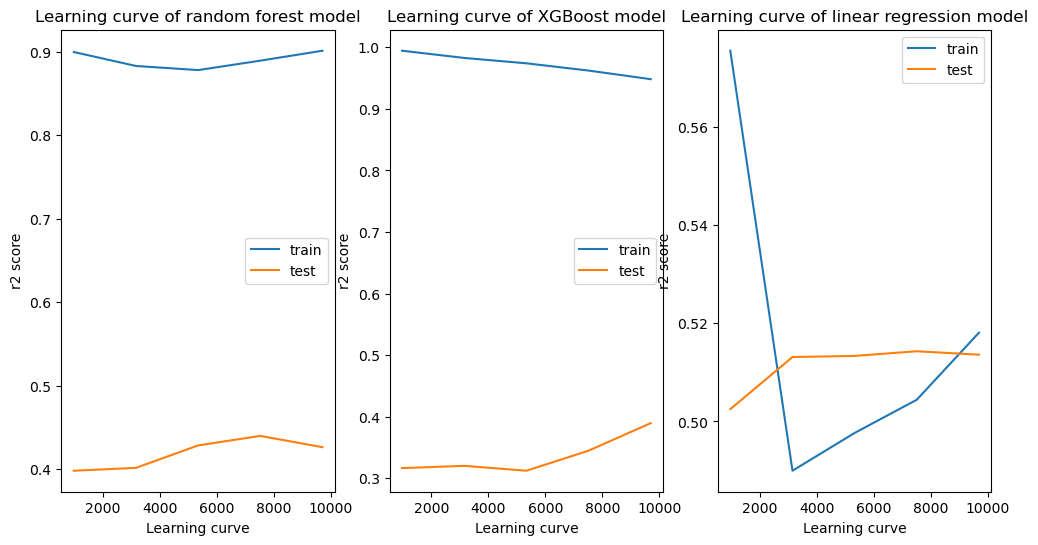

In [49]:
# Creating subplot with 1 row and 2 columns
fig, axes = plt.subplots(1,3, figsize=(12,6))

# Plotting learning curve of train and test set of random forest
axes[0].plot(train_sizes, train_mean_rf,label="train")
axes[0].plot(train_sizes, test_mean_rf,label="test")
axes[0].set_title("Learning curve of random forest model")
axes[0].set_ylabel("r2 score")
axes[0].set_xlabel("Learning curve")
axes[0].legend(loc="best")


# Plotting learning curve of train and test set of XGBoost 
axes[1].plot(train_sizes, train_mean_xgb,label="train")
axes[1].plot(train_sizes, test_mean_xgb,label="test")
axes[1].set_title("Learning curve of XGBoost model")
axes[1].set_ylabel("r2 score")
axes[1].set_xlabel("Learning curve")
axes[1].legend(loc="best")


# Plotting learning curve of train and test set of Linear Regression 
axes[2].plot(train_sizes, train_mean_lr,label="train")
axes[2].plot(train_sizes, test_mean_lr,label="test")
axes[2].set_title("Learning curve of linear regression model")
axes[2].set_ylabel("r2 score")
axes[2].set_xlabel("Learning curve")
axes[2].legend(loc="best")

Checking the learning curve of random forest, we see that the variance between the train and test set r2 score remains huge showing that the model was overfitting on the train set. The model was unable to learn the underlying patterns.  From the learning curve for XGBoost model, as the data increased the model was performing slightly better but overall the r2 value was bad compared to the training data. The variability was high but towards the end it reduced a bit. The model is performing really well on the training data but it is not performing well on the test data showing that the model is unable to generalise well or perform well with unseen data. In the linear regression model, the performance of the model reduced drastically on training data and then it saw a slight increase. The model's performance increase slightly on the test data but then it remained stagnant. The model was underfitting on the train data. 

# 4.2 Actual Vs Predicted value

Text(0.5, 0, 'Predicted Values')

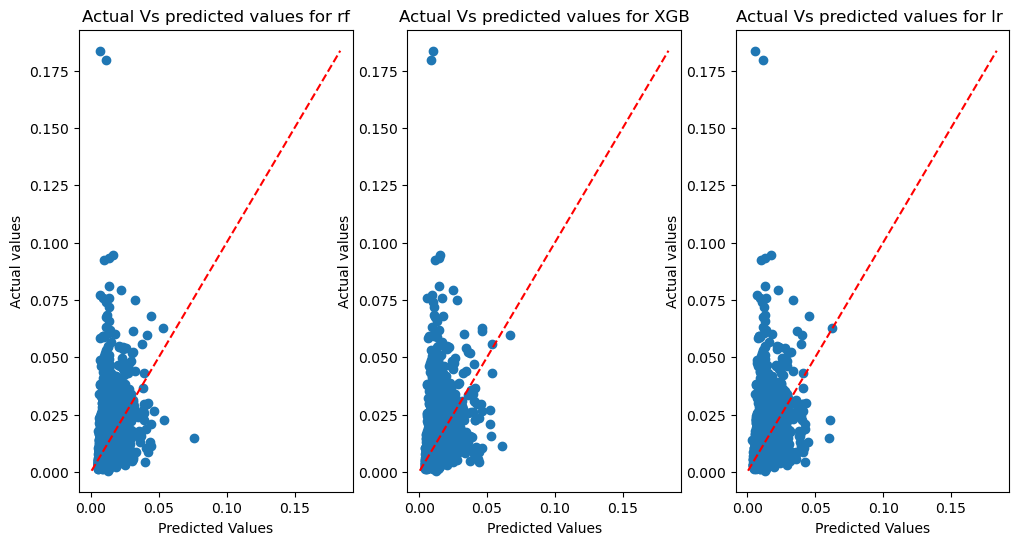

In [50]:
# Creating subplot with 1 row and 3 columns
fig, axes = plt.subplots(1,3, figsize=(12,6))


# Plotting Actual vs predicted value of random forest model
axes[0].scatter(y_pred_test_rf, y_test)
axes[0].plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], color="red", linestyle="--")
axes[0].set_title("Actual Vs predicted values for rf")
axes[0].set_ylabel("Actual values")
axes[0].set_xlabel("Predicted Values")

# Plotting Actual vs predicted value of XGBoost
axes[1].scatter(y_pred_test_xg, y_test)
axes[1].plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], color="red", linestyle="--")
axes[1].set_title("Actual Vs predicted values for XGB")
axes[1].set_ylabel("Actual values")
axes[1].set_xlabel("Predicted Values")

# Plotting Actual vs predicted value of Linear Regression
axes[2].scatter(y_pred_test_lr, y_test)
axes[2].plot([min(y_test),max(y_test)],[min(y_test),max(y_test)], color="red", linestyle="--")
axes[2].set_title("Actual Vs predicted values for lr ")
axes[2].set_ylabel("Actual values")
axes[2].set_xlabel("Predicted Values")

From the actual vs predicted graph we can see all the models could not predict the bigger values. Most of the points have variations from the actual values. Few of the smaller actual values were also overpredicted. The model is able to predict the values which are smaller better but as the values get bigger, the predictions does not get bigger. The models does not seem to learn about the underlying patterns and randomly predicting values between 0 and 0.050.

# 4.3 Residual Vs Fitted graph

Text(0.5, 0, 'Predicted Values')

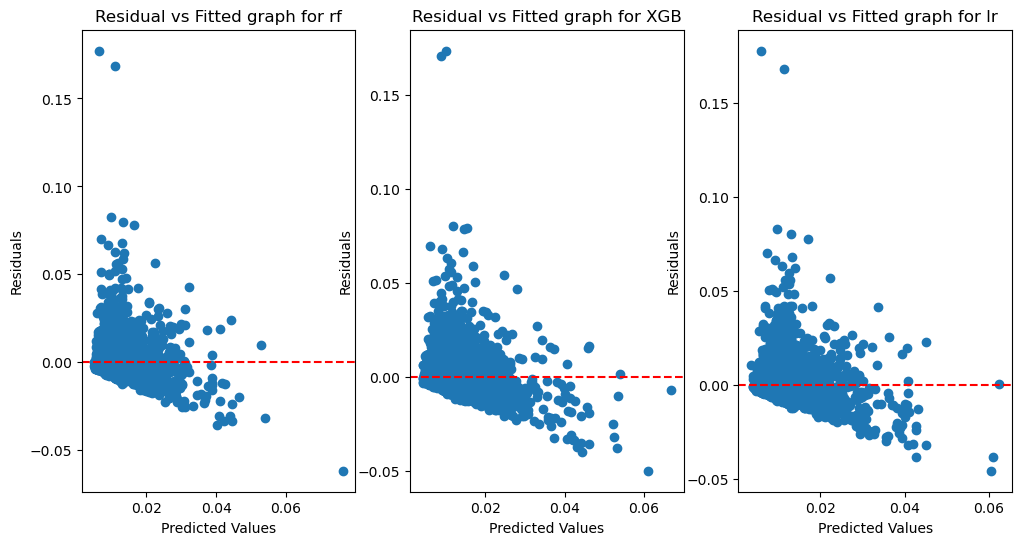

In [51]:
# Calculating residuals of Random forest 
residuals_rf = y_test-y_pred_test_rf
residuals_xg = y_test-y_pred_test_xg
residuals_lr = y_test-y_pred_test_lr

fig, axes = plt.subplots(1,3, figsize=(12,6))
# Plotting residual vs fitted graph for random forest
axes[0].scatter(y_pred_test_rf, residuals_rf)
axes[0].axhline(y=0, color="red", linestyle="--") 
axes[0].set_title("Residual vs Fitted graph for rf")
axes[0].set_ylabel("Residuals")
axes[0].set_xlabel("Predicted Values")

# Plotting residual vs fitted graph for XGBoost
axes[1].scatter(y_pred_test_xg, residuals_xg)
axes[1].axhline(y=0, color="red", linestyle="--") 
axes[1].set_title("Residual vs Fitted graph for XGB")
axes[1].set_ylabel("Residuals")
axes[1].set_xlabel("Predicted Values")

# Plotting residual vs fitted graph for Linear Regression
axes[2].scatter(y_pred_test_lr, residuals_lr)
axes[2].axhline(y=0, color="red", linestyle="--") 
axes[2].set_title("Residual vs Fitted graph for lr")
axes[2].set_ylabel("Residuals")
axes[2].set_xlabel("Predicted Values")

From the residual vs fitted graph, There are two points which was overestimated by all the three models. The maximum difference from the actual value is around 0.15 for all the three models. The values are distributed in a triangle shape and the residuals are fanning out which shows that as the predicted values increases the difference from actual values increases. The model has predicted values  between 0 and aroud 0.07 even though there are values as high as 0.183 in the y_test column as shown below.

In [52]:
y_test.describe()

count    3789.000000
mean        0.012012
std         0.010568
min         0.000505
25%         0.005675
50%         0.008849
75%         0.014727
max         0.183673
Name: Likes/Views, dtype: float64